# 1) Financial Phrases Data (Original training data)
---

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

pre_df = pd.read_csv('fin_sent_phrases.csv', encoding='iso-8859-1') 
pre_df.columns = ['sentiment', 'sentence']
print(sum(pre_df['sentiment'] == 'negative'), sum(pre_df['sentiment'] == 'neutral'), sum(pre_df['sentiment'] == 'positive'))
np_data = pre_df[(pre_df['sentiment']=='neutral') | (pre_df['sentiment']=='positive')]

604 2878 1363


# 2) Complaint Data
---

In [5]:
comp_df = pd.read_csv('complaints.csv')
comp_df = comp_df[['Date received', 'Product', 'Issue', 'Consumer complaint narrative', 'Company']]
comp_df.columns = ['date','product', 'issue', 'complaint', 'company']
comp_df = comp_df.dropna(subset=['complaint'])
pd.set_option('display.max_colwidth', None)
print(comp_df.shape)
comp_df.head()

/var/folders/h9/29cqk7qx1zg792pd6dlbxghm0000gn/T/ipykernel_92678/4025852125.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  comp_df = pd.read_csv('./Data/complaints.csv')


(2690358, 5)


,date,product,issue,complaint,company
21,2025-01-09,Credit reporting or other personal consumer reports,Incorrect information on your report,"I attempted to contact ChexSystems to dispute and remove information that does not belong to me and is adversely affecting my financial standing. I provided the neessary details and documentation to support my claim, emphasizing that the information was inaccurate and not associated with my accounts or activities.Despite my efforts to resolve the matter promptly and in good faith, I have not received any acknowledgment or response from ChexSystems, leaving the issue unresolved and continuing to impact me unfairly.","Fidelity National Information Services, Inc. (FNIS)"
24,2025-01-17,"Money transfer, virtual currency, or money service",Other transaction problem,"I am filing a complaint against Cash App ( Block , Inc. ) due to inadequate customer service and unfair practices, which violate the Consumer Financial Protection Act ( CFPA ). Specifically, Cash App failed to take timely and effective measures to prevent and address fraud on their platform, leaving my account vulnerable and unprotected. Furthermore, their dispute resolution process was unfair and deceptive, as they did not comply with error resolution requirements under the Electronic Fund Transfer Act ( EFTA ) and Regulation E. These actions have caused significant inconvenience and financial loss, and I seek appropriate redress for these violations.","Block, Inc."
33,2025-01-17,"Money transfer, virtual currency, or money service",Other transaction problem,"I am filing a complaint against Cash App ( Block , Inc. ) due to inadequate customer service and unfair practices, which violate the Consumer Financial Protection Act ( CFPA ). Specifically, Cash App failed to take timely and effective measures to prevent and address fraud on their platform, leaving my account vulnerable and unprotected.Furthermore, their dispute resolution process was unfair and deceptive, as they did not comply with error resolution requirements under the Electronic Fund Transfer Act ( EFTA ) and Regulation E. These actions have caused significant inconvenience and financial loss, and I seek appropriate redres for these violations.","Block, Inc."
38,2025-01-17,"Money transfer, virtual currency, or money service",Other transaction problem,"I am filing a complaint against Cash App ( Block , Inc. ) due to inadequate customer service and unfair practices, which violate the Consumer Financial Protection Act ( CFPA ). Specifically, Cash App failed to take timely and effective measures to prevent and address fraud on their platform, leaving my account vulnerable and unprotected.\n\nFurthermore, their dispute resolution process was unfair and deceptive, as they did not comply with error resolution requirements under the Electronic Fund Transfer Act ( EFTA ) and Regulation E. These actions have caused significant inconvenience and financial loss, and I seek appropriate redress for these violations","Block, Inc."
39,2025-01-17,"Money transfer, virtual currency, or money service",Other transaction problem,"I am filing a complaint against Cash App ( Block , Inc. ) due to inadequate customer service and unfair practices, which violate the Consumer Financial Protection Act ( CFPA ). Specifically, Cash App failed to take timely and effective measures to prevent and address fraud on their platform, leaving my account vulnerable and unprotected.\n\nFurthermore, their dispute resolution process was unfair and deceptive, as they did not comply with error resolution requirements under the Electronic Fund Transfer Act ( EFTA ) and Regulation E. These actions have caused significant inconvenience and financial loss, and I seek appropriate redress for these violations.","Block, Inc."


**2-1)Stratified Data**
---

In [7]:
import re
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import StratifiedShuffleSplit

comp_df['year'] = comp_df['date'].str.split('-').str[0].astype(int)
#comp_strat = comp_df.sample(n=500, random_state=42)
comp_df['stratify_col'] = comp_df['year'].astype(str) + '_' + comp_df['product'].astype(str)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=30)
comp_df_20_24 = comp_df[(comp_df['year']>=2020) & (comp_df['year']<=2024)]

for train_index, sample_index in stratified_split.split(comp_df_20_24, comp_df_20_24['stratify_col']):
    comp_strat = comp_df_20_24.iloc[sample_index]

def remove_parentheses(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\{[^)]*\}', '', text)
    text = re.sub(r'\(\s*[^()]*\s*\)', '', text)
    text = re.sub(r'\b(?:X{2,}|\/X{2,})\b', '', text)
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text

def text_split(texts): 
    comp_sen = []
    for text in texts: 
        clean_text = remove_parentheses(text) 
        tokenized_text = sent_tokenize(clean_text)
        comp_sen.extend(tokenized_text) 
    return comp_sen

strat_sample = list(comp_strat['complaint'])
strat_comp = text_split(strat_sample)
strat_sen = [sen for sen in strat_comp if len(sen) > 20]

len(strat_sen)

3501

In [8]:
# pre-training model 
import torch
from transformers import pipeline

task = "text-classification"
model_id = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

classifier1 = pipeline(task, model_id)
text = "Tesla cars are not as good as expected"
result = classifier1(text)
print(result)

strat_result = classifier1(strat_sen)

Device set to use mps:0


[{'label': 'negative', 'score': 0.996485710144043}]


In [9]:
result_label =[result['label'] for result in strat_result]
negative_strat_sen = [sentence for sentence, label in zip(strat_sen, result_label) if label == 'negative']
positive_strat_sen = [sentence for sentence, label in zip(strat_sen, result_label) if label == 'positive']
neutral_strat_sen = [sentence for sentence, label in zip(strat_sen, result_label) if label == 'neutral']
len(negative_strat_sen), len(positive_strat_sen), len(neutral_strat_sen)

(311, 45, 3145)

**2-2)Sample Data for Training**
---

In [11]:
comp_sample_sen = negative_strat_sen
comp_sample_df = pd.DataFrame(comp_sample_sen, columns = ['sentence'])
comp_sample_df['sentiment'] = 'relevant'
comp_sample_df = comp_sample_df[['sentiment', 'sentence']]
comp_sample_df

,sentiment,sentence
0,relevant,"It seems to be, asininely EXPERIAN, AND claimed that my account has been late on payments."
1,relevant,"EXPERIAN, AND failure to respond within 30 days of receipt of this certified letter and or your DEFICIENT OF COMPLIANT RESPONSE will indeed result in small claims legal action against EXPERIAN, AND at my local venue."
2,relevant,Any other notation is possibly refutable or even unlawful chichanary- led subterfuge which might be deemed an illegal infraction that creates potential unjustified consumer injury to which is OBVIOUSLY a SEVERE infringement of nay reporting ethics and standard of law.
3,relevant,I've run into a bit of a problem.
4,relevant,"While going through my credit report, I noticed some things that don't seem quite right, and it appears my identity have been stolen online."
...,...,...
306,relevant,Equifax refusal to supply this information yet still report false information has harmed my credit and therefore makes their actions illegal.
307,relevant,"As evidenced in the 5th Circuit Court of Appeals ruling I submitted on , the Appellate Court Reversed and Remanded the case finding Wells Fargo failed in submitting evidence proving it is the proper party to enforce the promissory note at issue on ."
308,relevant,"Wells Fargo has failed in proving it holds ownership of the Mortgage and Note at issue, yet they are claiming they assigned the Mortgage and Note to ."
309,relevant,"As evidenced in the submitted Appellate Court Ruling, the falsified and fraudulent affidavits submitted by both PHH Mortgage and were invalidated."


# 3) Data Join (Relevant, Neutral, Positive) 
---

In [13]:
sen_sample = pd.concat([comp_sample_df, np_data], axis=0)
label_map = {label: idx for idx, label in enumerate(sen_sample['sentiment'].unique())} #0: Relevant, 1: Neutral, 2: Positive
sen_sample['sentiment'] = sen_sample['sentiment'].map(label_map)
sen_sample

,sentiment,sentence
0,0,"It seems to be, asininely EXPERIAN, AND claimed that my account has been late on payments."
1,0,"EXPERIAN, AND failure to respond within 30 days of receipt of this certified letter and or your DEFICIENT OF COMPLIANT RESPONSE will indeed result in small claims legal action against EXPERIAN, AND at my local venue."
2,0,Any other notation is possibly refutable or even unlawful chichanary- led subterfuge which might be deemed an illegal infraction that creates potential unjustified consumer injury to which is OBVIOUSLY a SEVERE infringement of nay reporting ethics and standard of law.
3,0,I've run into a bit of a problem.
4,0,"While going through my credit report, I noticed some things that don't seem quite right, and it appears my identity have been stolen online."
...,...,...
4819,1,"Besides , as there is no depositor preference in Finland , senior debt and deposits rank on a par , which is also taken into consideration , the agency added ."
4821,2,The 2015 target for net sales has been set at EUR 1bn and the target for return on investment at over 20 % .
4822,1,"It holds 38 percent of Outokumpu 's shares and voting rights , but in 2001 lawmakers gave it permission to reduce the stake to 10 percent ."
4825,1,Mobile communication and wireless broadband provider Nokia Inc NYSE : NOK today set new financial targets and forecasts for Nokia and the mobile device industry and also for Nokia Siemens Networks and the mobile and fixed infrastructure and related services market .


**Data convertion and train/val/test split**
---

In [15]:
from torch.utils.data import random_split, DataLoader, Dataset
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

dataset = CustomDataset(
    texts=sen_sample['sentence'].to_numpy(),
    labels=sen_sample['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4) Model Training 
---

**4-1) epoch = 10**
---

In [23]:
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

model_id = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs.logits, dim=1)
    return (preds == labels).sum().item()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
avg_train_loss = []
avg_val_loss = []
avg_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
    
    avg_train_loss.append(total_train_loss / len(train_loader))
    
    # Validation loop
    model.eval()
    total_val_loss = 0
    total_accuracy = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy
            total_accuracy += calculate_accuracy(outputs, labels)
    
    avg_val_loss.append(total_val_loss / len(val_loader))
    avg_accuracy.append(total_accuracy / len(val_dataset))  # Divide by total number of samples
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss[epoch]:.4f}")
    print(f"Validation Loss: {avg_val_loss[epoch]:.4f}")
    print(f"Validation Accuracy: {avg_accuracy[epoch]:.4f}")

print("Training complete")

Epoch 1/10
Training Loss: 0.9039
Validation Loss: 0.8086
Validation Accuracy: 0.6340
Epoch 2/10
Training Loss: 0.7415
Validation Loss: 0.6691
Validation Accuracy: 0.6984
Epoch 3/10
Training Loss: 0.5899
Validation Loss: 0.6047
Validation Accuracy: 0.7116
Epoch 4/10
Training Loss: 0.4906
Validation Loss: 0.6099
Validation Accuracy: 0.7306
Epoch 5/10
Training Loss: 0.3803
Validation Loss: 0.6499
Validation Accuracy: 0.7365
Epoch 6/10
Training Loss: 0.2964
Validation Loss: 0.6920
Validation Accuracy: 0.7218
Epoch 7/10
Training Loss: 0.2202
Validation Loss: 0.7773
Validation Accuracy: 0.7277
Epoch 8/10
Training Loss: 0.1614
Validation Loss: 0.8787
Validation Accuracy: 0.7438
Epoch 9/10
Training Loss: 0.1222
Validation Loss: 1.0091
Validation Accuracy: 0.7116
Epoch 10/10
Training Loss: 0.0977
Validation Loss: 1.0088
Validation Accuracy: 0.7379
Training complete


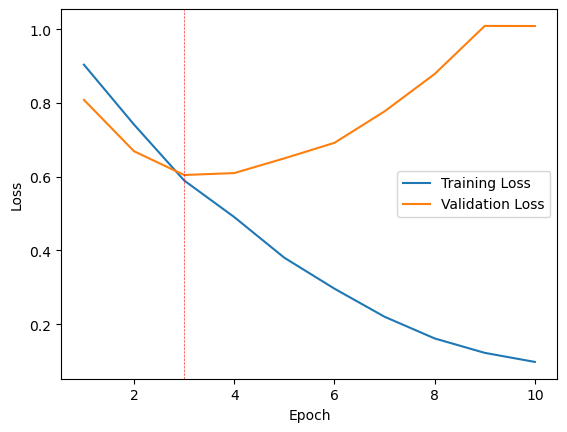

In [45]:
from matplotlib import pyplot as plt

epochs = range(1, len(avg_train_loss) + 1)  # Start from 1
optimal_epoch = np.argmin(avg_val_loss)+1

plt.plot(epochs, avg_train_loss, label='Training Loss')
plt.plot(epochs, avg_val_loss, label='Validation Loss')
plt.axvline(x=optimal_epoch, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**4-2) epoch = 3**
---

In [47]:
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

model_id = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)


optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = optimal_epoch # optimal epoch from the trial above
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs.logits, dim=1)
    return (preds == labels).sum().item()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

avg_train_loss = []
avg_val_loss = []
avg_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
    
    avg_train_loss.append(total_train_loss / len(train_loader))
    
    # Validation loop
    model.eval()
    total_val_loss = 0
    total_accuracy = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy
            total_accuracy += calculate_accuracy(outputs, labels)
    
    avg_val_loss.append(total_val_loss / len(val_loader))
    avg_accuracy.append(total_accuracy / len(val_dataset))  # Divide by total number of samples
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss[epoch]:.4f}")
    print(f"Validation Loss: {avg_val_loss[epoch]:.4f}")
    print(f"Validation Accuracy: {avg_accuracy[epoch]:.4f}")

print("Training complete")

Epoch 1/3
Training Loss: 0.9368
Validation Loss: 0.8213
Validation Accuracy: 0.6281
Epoch 2/3
Training Loss: 0.7803
Validation Loss: 0.7366
Validation Accuracy: 0.6530
Epoch 3/3
Training Loss: 0.6866
Validation Loss: 0.6663
Validation Accuracy: 0.7057
Training complete


In [50]:
from huggingface_hub import HfApi
from transformers import AutoModel, AutoTokenizer

api = HfApi()
repo_name = "my-finetuned-model"
api.create_repo(repo_name, exist_ok=True)

model.push_to_hub("financial-news-complaint-relevence-analysis-model")
tokenizer.push_to_hub("financial-news-complaint-relevence-analysis-model")

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/tedheo/financial-news-complaint-relevence-analysis-model/commit/34a1663833b471029dc03d8ca6a8a79dc644ead6', commit_message='Upload tokenizer', commit_description='', oid='34a1663833b471029dc03d8ca6a8a79dc644ead6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tedheo/financial-news-complaint-relevence-analysis-model', endpoint='https://huggingface.co', repo_type='model', repo_id='tedheo/financial-news-complaint-relevence-analysis-model'), pr_revision=None, pr_num=None)

**4-3) Model Result Decoder and Test**
---

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

task = "text-classification"
model_id = "tedheo/financial-news-complaint-relevence-analysis-model"
classifier2 = pipeline(task, model_id)

def result_decoder(texts):
    mapping = {'negative': 'relevant', 'neutral': 'irrelevant', 'positive': 'irrelevant'}
    results = classifier2(texts)  
    for result in results:
        result['label'] = mapping[result['label']]
    return results

sample_texts = [
    "The stock market is performing exceptionally well today.",
    "I am filing a complaint against Cash App due to inadequate customer service and unfair practices, which violate the Consumer Financial Protection Act .",
    "The 2015 target for net sales has been set at EUR 1bn and the target for return on investment at over 20 % .",
    "Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .",
    "Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres ."    
]

results = result_decoder(sample_texts) # need to change the label from negative neutral positive to relevant irrelevant
for result in results:
    print(result)

Device set to use mps:0


{'label': 'irrelevant', 'score': 0.7767212390899658}
{'label': 'irrelevant', 'score': 0.5827060341835022}
{'label': 'irrelevant', 'score': 0.7482746839523315}
{'label': 'relevant', 'score': 0.990906834602356}
{'label': 'relevant', 'score': 0.6770784258842468}


In [30]:
original_labels = classifier1(sample_texts)
for label in original_labels:
    print(label)

{'label': 'positive', 'score': 0.999562680721283}
{'label': 'neutral', 'score': 0.678717315196991}
{'label': 'neutral', 'score': 0.9997524619102478}
{'label': 'negative', 'score': 0.9985373020172119}
{'label': 'negative', 'score': 0.9913457632064819}


# 4-4) Evaluation
---

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

sen_train, sen_test= train_test_split(sen_sample, test_size=0.3, random_state=42, stratify = sen_sample['sentiment'])

texts = sen_test['sentence'].tolist()  
true_labels = sen_test['sentiment'].tolist()  
predictions = classifier2(texts, truncation=True, padding=True)
predicted_labels = [pred['label'] for pred in predictions]

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
predicted_labels_ids = [label_mapping[label] for label in predicted_labels]

accuracy = accuracy_score(true_labels, predicted_labels_ids)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels_ids, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8638
Precision: 0.8626
Recall: 0.8137
F1 Score: 0.8355


# 5) Test Operation
---

**5-1) Get the text from an article url**
---

In [35]:
import requests
import re
import nltk
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
from readability import Document

def remove_parentheses(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\{[^)]*\}', '', text)
    text = re.sub(r'\(\s*[^()]*\s*\)', '', text)
    text = re.sub(r'\b(?:X{2,}|\/X{2,})\b', '', text)
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text

def fetch_article_text(url):
    # Download the article HTML
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the request was unsuccessful

    # Use readability to parse HTML
    doc = Document(response.text)
    article_text = doc.summary()

    # If you want only the text without HTML tags, use BeautifulSoup
    soup = BeautifulSoup(article_text, 'html.parser')
    
    article_text = soup.get_text(separator=' ')
    split_text = article_text.split('\t')
    article_sample_sen = []

    for text in split_text: 
        clean_text = remove_parentheses(text) 
        clean_sen = sent_tokenize(clean_text)
        article_sample_sen.extend(clean_sen) 
        
    return article_sample_sen

url1 = 'https://www.cnn.com/2025/04/09/investing/global-stock-market-reciprocal-tariffs-hnk-intl/index.html'
url2 = 'https://www.thearmchairtrader.com/currencies/korean-won-forecast-martial-law/'
url3 = 'https://economictimes.indiatimes.com/news/international/global-trends/the-financial-crisis-of-2025-better-to-be-ready/articleshow/120344209.cms?from=mdr'
url4 = 'https://www.cnn.com/2022/08/03/business/equifax-wrong-credit-scores/index.html'
url5 = 'https://www.pymnts.com/economy/2024/consumers-paid-price-overstated-job-growth-that-kept-interest-rates-too-high/'
url6 = 'https://www.who.int/westernpacific/newsroom/feature-stories/item/improving-food-safety--lessons-learned-from-a-food-poisoning-outbreak'

article_text1 = fetch_article_text(url1) # Tariffs Crisis
article_text2 = fetch_article_text(url2) # South Korea Political Turmoil
article_text3 = fetch_article_text(url3) # Financial Crisis Anxiety
article_text4 = fetch_article_text(url4) # Incorrect Credit Scores 
article_text5 = fetch_article_text(url5) # Overstated Job Growth 
article_text6 = fetch_article_text(url6) # Food Poisoning Outbreak

**5-2) Relevence Check**
---

In [37]:
# Test : an article has at least 3 sentence have relevence with score >= 0.97
def is_relevant(results_list):
    rel = False
    rel_count = 0 
    for result in results_list: 
        if (result['label']=='relevant') & (result['score']>=0.90):
            rel_count += 1
    if rel_count >= 2: 
        rel = True
    return rel

result1 = result_decoder(article_text1)
result2 = result_decoder(article_text2)
result3 = result_decoder(article_text3)
result4 = result_decoder(article_text4)
result5 = result_decoder(article_text5)
result6 = result_decoder(article_text6) 

print("Article 1", is_relevant(result1))
print("Article 2", is_relevant(result2))
print("Article 3", is_relevant(result3))
print("Article 4", is_relevant(result4))
print("Article 5", is_relevant(result5))
print("Article 6", is_relevant(result6))

Article 1 True
Article 2 True
Article 3 False
Article 4 True
Article 5 False
Article 6 False
